In [1]:
#Here I import the needed libraries

from math import exp
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score

In [6]:
#I had the file downloaded and extracted to save time extracing each time I ran, you can do the
#same or impliment a different approach
file=open("C:/Users/alecj/Desktop/Nat2020PublicUS.c20210506.r20210812.txt",'r')
lines=file.readlines()
file.close()

In [7]:
#Here I read in the variables by their location in the line
#Be careful as the guide is wrong and lists one of the mother's race items as a len of 2 when it is one
#if you do your own that may run into issues but these are the correct locations for the 2020 collection

weight=[]
fathage=[]
mothage=[]
mothrace=[]
prenvist=[]
preterm=[]
for line in lines:
    weight.append(line[510])
    fathage.append(line[146:148])
    mothage.append(line[74:76])
    mothrace.append(line[106])
    prenvist.append(line[237:239])
    preterm.append(line[502])


In [8]:
#I create the dataframe from the variables
df=pd.DataFrame({'Weight':weight, 'Fathers Age':fathage, 'Mothers Age':mothage, 'Mothers Race':mothrace, "Num of Visits":prenvist, 'PreTerm':preterm })

In [9]:
#I set the types so I can replace the needed values
#There is probably an easier way to do this but I didn't know how
df['Weight']=df['Weight'].astype('int')
df['Fathers Age']=df['Fathers Age'].astype('int')
df['Mothers Age']=df['Mothers Age'].astype('int')
df['Mothers Race']=df['Mothers Race'].astype('int')
df['Num of Visits']=df['Num of Visits'].astype('int')
df['PreTerm']=df['PreTerm'].astype('int')

In [10]:
#Reassigns the weights to the needed values
df['Weight']=df['Weight'].replace(2,1)
df['Weight']=df['Weight'].replace(3,0)
df['Weight']=df['Weight'].replace(4,np.NaN)


In [11]:
#Same thing but for other values, including assigning more NAs
df['PreTerm']=df['PreTerm'].replace(2,0)
df['PreTerm']=df['PreTerm'].replace(3,np.NaN)
df['Num of Visits']=df['Num of Visits'].replace(99,np.NaN)
df['Fathers Age']=df['Fathers Age'].replace(99,np.NaN)
df['Mothers Race']=df['Mothers Race'].replace(8,np.NaN)


In [12]:
##note to myself
#preterm 1 is under 37 weeks, 0 is over
#weight 1 is underwieght

In [59]:
np.shape(df)

(3619826, 6)

In [13]:
#creates a new dataframe without the NAs
new=df.dropna()
new

,Weight,Fathers Age,Mothers Age,Mothers Race,Num of Visits,PreTerm
0,0.0,30.0,25,1,10.0,0.0
1,0.0,27.0,28,1,15.0,0.0
2,0.0,35.0,36,1,8.0,0.0
3,0.0,34.0,32,1,9.0,0.0
5,0.0,42.0,34,4,11.0,0.0
...,...,...,...,...,...,...
3619813,1.0,51.0,33,1,0.0,1.0
3619815,1.0,22.0,22,6,3.0,0.0
3619817,0.0,38.0,26,2,13.0,0.0
3619818,0.0,41.0,36,1,15.0,0.0


In [14]:
#Reassigns types that were broken when assigning NAs, probably better way to do this
new['Weight']=new['Weight'].astype('int')
new['Fathers Age']=new['Fathers Age'].astype('int')
new['Mothers Age']=new['Mothers Age'].astype('int')
new['Mothers Race']=new['Mothers Race'].astype('category')
new['Num of Visits']=new['Num of Visits'].astype('int')
new['PreTerm']=new['PreTerm'].astype('category')

In [61]:
#Calculated the sizes of the old and new DFs
newsize=new.size/6
oldsize=df.size/6
change=(df.size/6)-(new.size/6)
print('The old size is:',oldsize)
print('The new size is:', newsize)
print('The rows removed is:',change)
print('Or',change/oldsize, 'Percent' )

The old size is: 3619826.0
The new size is: 3096462.0
The rows removed is: 523364.0
Or 0.1445826401600519 Percent


In [16]:
cord=new.corr()
cord

,Weight,Fathers Age,Mothers Age,Num of Visits
Weight,1.000000,0.006218,0.006380,-0.094376
Fathers Age,0.006218,1.000000,0.742635,0.034864
Mothers Age,0.006380,0.742635,1.000000,0.063454
Num of Visits,-0.094376,0.034864,0.063454,1.000000


<AxesSubplot:>

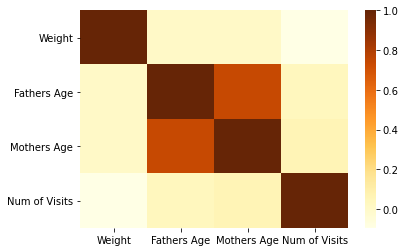

In [17]:
sns.heatmap(cord,cmap='YlOrBr')

Text(0.5, 1.0, 'Fathers Age')

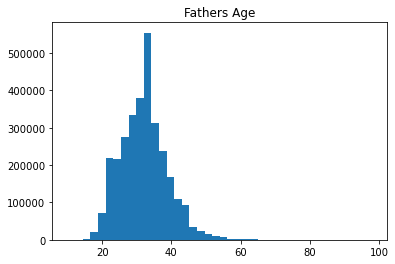

In [41]:

plt.hist(new['Fathers Age'],bins=40)
plt.title("Fathers Age")

Text(0.5, 1.0, 'Mothers Age')

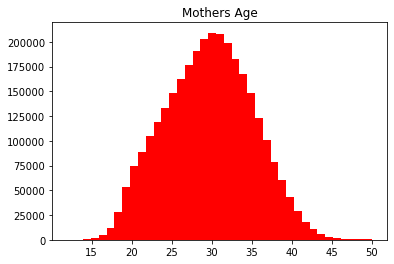

In [40]:
plt.hist(new['Mothers Age'],bins=39,color='red')
plt.title("Mothers Age")

Text(0.5, 1.0, 'Number of Prenatal Visits')

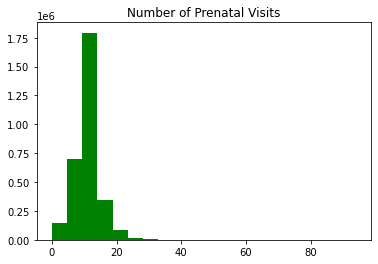

In [42]:
plt.hist(new['Num of Visits'],bins=20,color='green')
plt.title("Number of Prenatal Visits")


From left to right: ['White', 'Black', 'AIAN', 'Asian', 'NHOPI', 'Mixed Race']


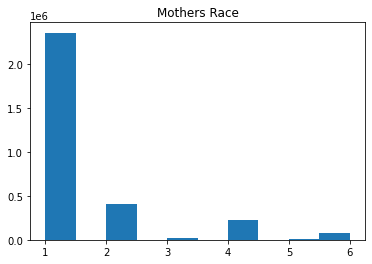

In [58]:
labels = ['White', "Black", "AIAN", "Asian", "NHOPI","Mixed Race"]
plt.hist(new['Mothers Race'], label=labels)
plt.title("Mothers Race")
print("From left to right:",labels)

In [180]:
#Ran a vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
vifmod=new.drop(columns='Weight')
vif=pd.Series([variance_inflation_factor(vifmod.values, i) for i in range(vifmod.shape[1])], index=vifmod.columns)
vif


Fathers Age      49.960285
Mothers Age      53.719426
Mothers Race      2.714834
Num of Visits     7.327360
PreTerm           1.112084
dtype: float64

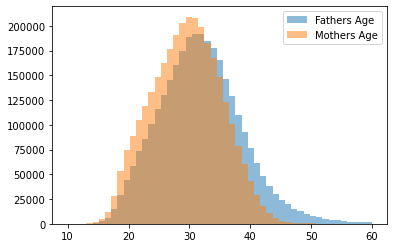

In [181]:
#vif of Father and Mothers age were high, makes sense as they are almost 1:1
bins=np.linspace(10, 60)
plt.hist(new['Fathers Age'],bins, alpha=0.5, label='Fathers Age')
plt.hist(new['Mothers Age'],bins, alpha=0.5, label='Mothers Age')
plt.legend(loc='upper right')
plt.show()

In [182]:
#tried again without the Fathers Age
nodad=vifmod.drop(columns='Fathers Age')
vif2=pd.Series([variance_inflation_factor(nodad.values, i) for i in range(nodad.shape[1])], index=nodad.columns)
vif2

Mothers Age      8.795942
Mothers Race     2.696110
Num of Visits    7.288997
PreTerm          1.111945
dtype: float64

In [194]:
#Still high values so I dropped Num of Visits since I cannot get rid of the Mothers Age
novisits=nodad.drop(columns='Num of Visits')
vif3=pd.Series([variance_inflation_factor(novisits.values, i) for i in range(novisits.shape[1])], index=novisits.columns)
vif3

Mothers Age     2.773352
Mothers Race    2.685669
PreTerm         1.102411
dtype: float64

In [195]:
#Tried with fathers age in it still but no num of visits
novisits2=vifmod.drop(columns='Num of Visits')
vif4=pd.Series([variance_inflation_factor(novisits2.values, i) for i in range(novisits2.shape[1])], index=novisits2.columns)
vif4


Fathers Age     49.698719
Mothers Age     49.867260
Mothers Race     2.706367
PreTerm          1.102433
dtype: float64

Count of Under Weight births: 230957
Count of Healthy Weight births: 2865505
Percentage that are underweight: 0.07458738392397517


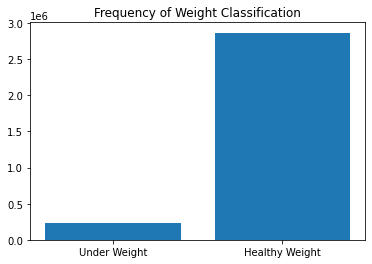

In [184]:
#Counted how many instances of Under and Normal Weight there was
x=0
y=0
for i in enumerate(new['Weight']):
    if int(i[1]) == 1:
        x+=1
    elif int(i[1])==0:
        y+=1
data={'Under Weight':x, 'Healthy Weight':y}
key=list(data.keys())
val=list(data.values())
plt.bar(key,val)
plt.title('Frequency of Weight Classification')

print('Count of Under Weight births:', x)
print('Count of Healthy Weight births:', y)
print('Percentage that are underweight:', x/(x+y))

In [185]:
#base model
y1=new['Weight']
X1=new.drop('Weight', axis=1).values
X_train1, X_test1, y_train1, y_test1=train_test_split(X1,y1,train_size=.8,random_state=321)

#hold=new to save code
hold=new.drop(columns='Fathers Age')

#no father age
y2=hold['Weight']
X2=hold.drop('Weight', axis=1).values
X_train2, X_test2, y_train2, y_test2=train_test_split(X2,y2,train_size=.8,random_state=321)
#no visits either
hold=hold.drop(columns='Num of Visits')
y3=hold['Weight']
X3=hold.drop('Weight', axis=1).values
X_train3, X_test3, y_train3, y_test3=train_test_split(X3,y3,train_size=.8,random_state=321)

Accuracy Score: 0.9341975446194289
Confusion Matrix: 
[[550760  22231]
 [ 18520  27782]]
Area Under Curve: 0.7806095558785321
Recall score: 0.6000172778713663


Text(0.7, 0.2, 'AUC0.781')

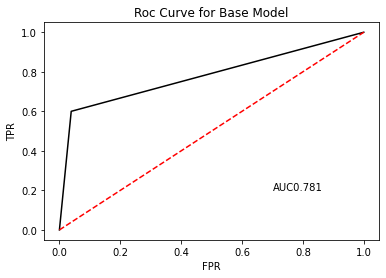

In [186]:
#first model with everything in it
lg1 = LogisticRegression(random_state=123, class_weight=None)
lg1.fit(X_train1,y_train1)
y_pred1 = lg1.predict(X_test1)

print(f'Accuracy Score: {accuracy_score(y_test1,y_pred1)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test1, y_pred1)}')
print(f'Area Under Curve: {roc_auc_score(y_test1, y_pred1)}')
print(f'Recall score: {recall_score(y_test1,y_pred1)}')

auc=mt.roc_auc_score(y_test1,y_pred1)
fpr, tpr, th = mt.roc_curve(y_test1,y_pred1)
plt.plot(fpr,tpr,'k-')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,.1),'r--')
plt.title("Roc Curve for Base Model")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.text(.7,.2,'AUC'+"{:.3f}".format(auc))

Accuracy Score: 0.9342023888530954
Confusion Matrix: 
[[550720  22271]
 [ 18477  27825]]
Area Under Curve: 0.7810389941092993
Recall score: 0.6009459634573021


Text(0.7, 0.2, 'AUC0.781')

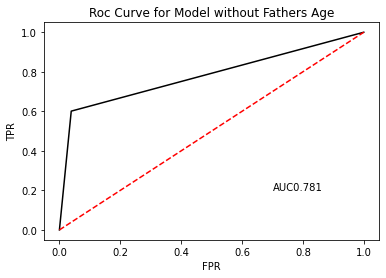

In [187]:
#second model with Fathers age removed
lg2 = LogisticRegression(random_state=123, class_weight=None)
lg2.fit(X_train2,y_train2)
y_pred2 = lg2.predict(X_test2)

print(f'Accuracy Score: {accuracy_score(y_test2,y_pred2)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test2, y_pred2)}')
print(f'Area Under Curve: {roc_auc_score(y_test2, y_pred2)}')
print(f'Recall score: {recall_score(y_test2,y_pred2)}')

auc=mt.roc_auc_score(y_test2,y_pred2)
fpr, tpr, th = mt.roc_curve(y_test2,y_pred2)
plt.plot(fpr,tpr,'k-')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,.1),'r--')
plt.title("Roc Curve for Model without Fathers Age")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.text(.7,.2,'AUC'+"{:.3f}".format(auc))

Accuracy Score: 0.9336872853398956
Confusion Matrix: 
[[546757  26234]
 [ 14833  31469]]
Area Under Curve: 0.8169311766458838
Recall score: 0.6796466675305602


Text(0.7, 0.2, 'AUC0.817')

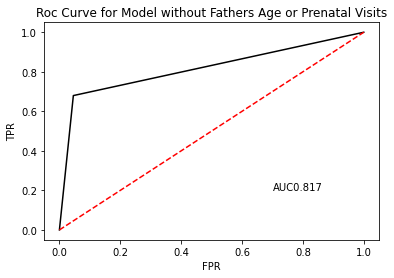

In [188]:
#Third without Fathers Age or Num of visits
lg3 = LogisticRegression(random_state=123, class_weight=None)
lg3.fit(X_train3,y_train3)
y_pred3 = lg3.predict(X_test3)

print(f'Accuracy Score: {accuracy_score(y_test3,y_pred3)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test3, y_pred3)}')
print(f'Area Under Curve: {roc_auc_score(y_test3, y_pred3)}')
print(f'Recall score: {recall_score(y_test3,y_pred3)}')

auc=mt.roc_auc_score(y_test3,y_pred3)
fpr, tpr, th = mt.roc_curve(y_test3,y_pred3)
plt.plot(fpr,tpr,'k-')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,.1),'r--')
plt.title("Roc Curve for Model without Fathers Age or Prenatal Visits")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.text(.7,.2,'AUC'+"{:.3f}".format(auc))

In [135]:
#base: 0:2865505, 1:230957
#Tried different weights on the third model to see if that improved scores at all
model = LogisticRegression()
# define hyperparameters
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
grid_result = grid.fit(X_train3, y_train3)

In [136]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.840952 using {'class_weight': {0: 10, 1: 1}}


Accuracy Score: 0.9252340975919314
Confusion Matrix: 
[[572991      0]
 [ 46302      0]]
Area Under Curve: 0.5
Recall score: 0.0


Text(0.7, 0.2, 'AUC0.500')

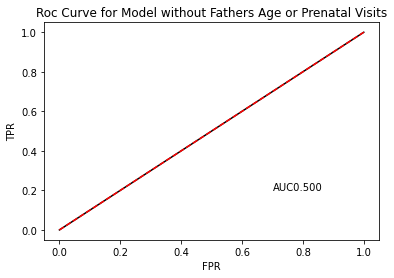

In [189]:
#Tried the same values as the third regression with the best selected weight
lg4 = LogisticRegression(random_state=123, class_weight={0: 10, 1: 1})
lg4.fit(X_train3,y_train3)
y_pred4 = lg4.predict(X_test3)

print(f'Accuracy Score: {accuracy_score(y_test3,y_pred4)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test3, y_pred4)}')
print(f'Area Under Curve: {roc_auc_score(y_test3, y_pred4)}')
print(f'Recall score: {recall_score(y_test3,y_pred4)}')

auc=mt.roc_auc_score(y_test3,y_pred4)
fpr, tpr, th = mt.roc_curve(y_test3,y_pred4)
plt.plot(fpr,tpr,'k-')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,.1),'r--')
plt.title("Roc Curve for Model without Fathers Age or Prenatal Visits")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.text(.7,.2,'AUC'+"{:.3f}".format(auc))

In [190]:
odds=np.exp(lg3.coef_[0])
pd.DataFrame(odds,novisits.columns,columns=['coef'])\
            .sort_values(by='coef', ascending=False)


,coef
PreTerm,45.616046
Mothers Race,1.128580
Mothers Age,0.991431


In [5]:
##Do not run, relic of orignal attempt



print(text[0])
#1 birhtyear/month
#2 birthtime/day of week
#3 birthplace,reporting
#4 facility
#5 age, need the first 2
#6 Mother’s Nativity 
#7Residence Status/Mother’s Race Recode 31/Mother’s Race Recode 6/Mother’s Race Recode 15(need race record 6, the 2 before the last 2)
#8 Hispanic
#9 Hispanic
#10 father known/married
#11 mothers education
#12 flag for education
#13 fathers age used
#14 fathers age, need first 2
#15 father hispanic
#16 education of father
#17 priorchildre,living,dead,aborted
#18 live births
#19 total births
#20 since last birth
#21 since last pregnancy
#22 month prenatal care began
#23 number of prenatal visits
#24 number of prenatal visits
#25 Wic
#26 height
#27 prepreg wieght
#28 del weight
#29 weight gain
#30 issues
#31 cesarean
#32 stds
#33 Cephalic
#34 succesful Cephalic
#35 treatments used
#36 delivery details
#37 Maternal Morbidity
#38 More health
#39 No Maternal Morbidity Reported
#40 attendent
#41 agpar score
#42 plurality
#43 plurality
#44 more recode
#45 sex of infant, imputed
#46 last menses month
#47 last menses year
#48 more stuff last 4 is weigh
#49 weight records will use this
#50 Flags
#51 Newborn sick
#52 sick flags
#53 Anomalies
#54 misc
len(text[0])

['202001', '11234', '11', '1', '25094', '1', '101101', '0', '011', 'X1', '13', '1', '300501101', '00113', '1', '000000', '1', '1', '88888', '88888', '88888', '0412', '10', '061', 'N10000000000001111N1', '62126.53', '1451', '180', '13541', 'NNNNNN111111NXX111N00', '111', 'NNNNN111111', 'NN', '11', 'YNNYYY1111110', '14Y111321', 'NNNNN', '11111', '1', '2N5411', '0831885', '1', '9', 'M', '03', '2019', '40082', '400823570', '083', 'NNNNNN', '111111', '1', 'NNNNNN111111NNNNNN1111111', 'NYY1']


54